In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

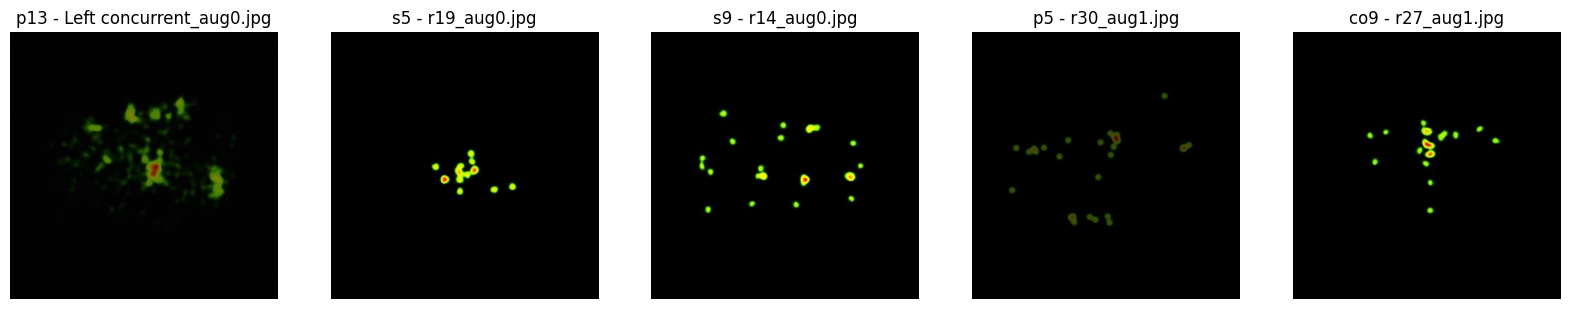

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

!cp -r '/content/drive/My Drive/heat_maps/transparent_heat_maps_augmented' /content/local_heat_maps
base_image_directory = '/content/local_heat_maps'

# List files in the directory
image_files = os.listdir(base_image_directory)

# Display a few images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axes):
    if i < len(image_files):
        img_path = os.path.join(base_image_directory, image_files[i])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{image_files[i]}")
    else:
        ax.axis('off')

plt.show()


# **ResNet50**

In [ ]:
import os
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.optim as optim
import torch.nn as nn
from PIL import Image

!cp -r '/content/drive/My Drive/heat_maps/transparent_heat_maps_augmented' /content/local_heat_maps
base_image_directory = '/content/local_heat_maps'

# Functions to categorize images based on their filename
def categorize_image(filename):
    if filename.startswith('co'):
        return 'continuity'
    elif filename.startswith('Co'):
        return 'continuity'
    elif filename.startswith('f'):
        return 'figure_ground'
    elif filename.startswith('s'):
        return 'similarity'
    elif filename.startswith('p'):
        return 'proximity'
    else:
        return 'unknown'

def categorize_recording(filename):
    filename = filename.lower()
    if 'concurrent' in filename:
        return 'cumulative'
    import re
    match = re.search(r'r(\d{1,2})', filename)
    if match:
        participant_num = int(match.group(1))
        return f'participant{participant_num}'
    return 'unknown'


# Function to generate CSV
def generate_csv(directory, csv_filename):
    image_files = os.listdir(directory)

    # Filtering out non-image files
    image_files = [f for f in image_files if f.lower().endswith('.jpg')]

    # Creating a new list of labels based on the rule
    data = []
    for image in image_files:
        category = categorize_image(image)
        participant = categorize_recording(image)
        data.append([image, category, participant])

    # Writing the data to a new CSV file
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename', 'Category', 'Participant'])
        writer.writerows(data)

# Generating CSV files for the entire set
generate_csv(base_image_directory, 'transparent_labels.csv')

# Loading the data into pandas DataFrame
all_df = pd.read_csv('transparent_labels.csv')
all_df = all_df[~all_df['Participant'].isin(['participant5', 'participant28'])].reset_index(drop=True)
all_df = all_df.drop(columns=["Participant"])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),  # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.6, saturation=0.6, hue=0.2),  # Adjust brightness, contrast, etc.
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# PhotographyDataset class
class PhotographyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # Filename
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]  # Category

        if self.transform:
            image = self.transform(image)

        # Converting label to numeric encoding
        label_map = {'continuity': 0, 'figure_ground': 1, 'similarity': 2, 'proximity': 3}
        label = label_map[label]

        return image, label


# Train, Val, Test Split
train_size = 0.70
val_size = 0.15
test_size = 0.15
assert train_size + val_size + test_size == 1.0

train_df, val_df, test_df = np.split(all_df.sample(frac=1, random_state=45482),
                                      [int(train_size * len(all_df)), int((train_size + val_size) * len(all_df))])

# Saving the new CSV files for train, val, and test
train_df.to_csv('train_photography_labels.csv', index=False)
val_df.to_csv('val_photography_labels.csv', index=False)
test_df.to_csv('test_photography_labels.csv', index=False)

# Loading the new CSVs into pandas DataFrames
train_df = pd.read_csv('train_photography_labels.csv')
val_df = pd.read_csv('val_photography_labels.csv')
test_df = pd.read_csv('test_photography_labels.csv')

# Initializing the datasets for training, validation, and testing
train_dataset = PhotographyDataset(csv_file='train_photography_labels.csv', root_dir=base_image_directory, transform=train_transform)
val_dataset = PhotographyDataset(csv_file='val_photography_labels.csv', root_dir=base_image_directory, transform=val_transform)
test_dataset = PhotographyDataset(csv_file='test_photography_labels.csv', root_dir=base_image_directory, transform=test_transform)

# Calculating class weights
labels = [item[1] for item in train_dataset]  # Assuming labels are stored in the second position of dataset items
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# DataLoader for training, validation, and testing
trainloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valloader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
print(f"Train dataset size: {len(trainloader.dataset)}")
print(f"Validation dataset size: {len(valloader.dataset)}")
print(f"Test dataset size: {len(testloader.dataset)}")

Train dataset size: 2601
Validation dataset size: 558
Test dataset size: 558


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Accuracy: 43.41%, Validation Accuracy: 50.90%
Epoch [2/20], Train Accuracy: 53.52%, Validation Accuracy: 61.65%
Epoch [3/20], Train Accuracy: 61.51%, Validation Accuracy: 64.87%
Epoch [4/20], Train Accuracy: 66.13%, Validation Accuracy: 69.53%
Epoch [5/20], Train Accuracy: 69.59%, Validation Accuracy: 71.15%
Epoch [6/20], Train Accuracy: 73.78%, Validation Accuracy: 75.45%
Epoch [7/20], Train Accuracy: 77.39%, Validation Accuracy: 80.82%
Epoch [8/20], Train Accuracy: 80.24%, Validation Accuracy: 79.93%
Epoch [9/20], Train Accuracy: 81.16%, Validation Accuracy: 82.44%
Epoch [10/20], Train Accuracy: 82.97%, Validation Accuracy: 84.23%
Epoch [11/20], Train Accuracy: 83.54%, Validation Accuracy: 84.05%
Epoch [12/20], Train Accuracy: 83.93%, Validation Accuracy: 84.95%
Epoch [13/20], Train Accuracy: 81.85%, Validation Accuracy: 86.02%
Epoch [14/20], Train Accuracy: 82.51%, Validation Accuracy: 86.20%
Epoch [15/20], Train Accuracy: 82.12%, Validation Accuracy: 83.51%
Epoc

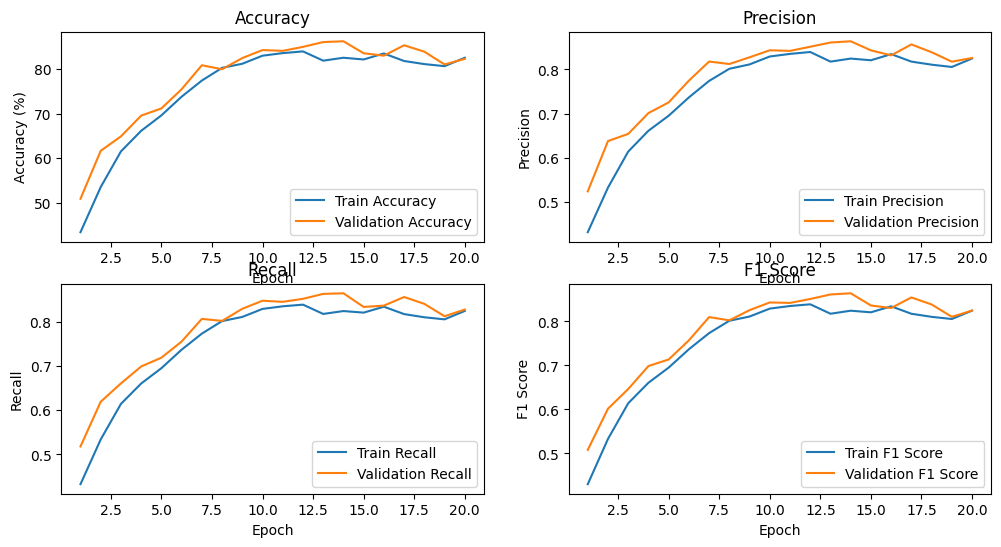

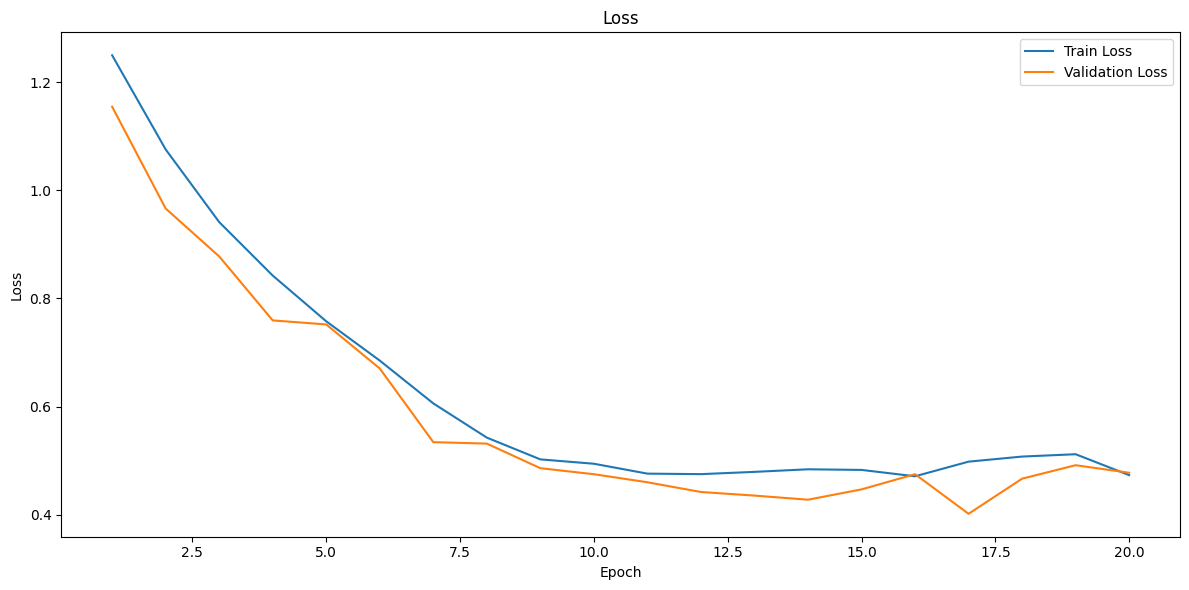

In [ ]:
# Initializing the model ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# Adding Dropout to prevent overfitting
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 64),
    nn.ReLU(),
    nn.Dropout(p=0.125), # Increase Dropout if the model overfits
    nn.Linear(64, 4),
)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001,
                       weight_decay=0.001) # Increase weight decay if the model overfits


# Learning rate scheduler (StepLR example)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Storing the metrics
train_accuracy_list = []
val_accuracy_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []
train_f1_list = []
val_f1_list = []
train_loss_list = []
val_loss_list = []

# Training
num_epochs = 20
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Calculating training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Storing loss and predictions for later metrics calculation
        train_loss += loss.item()
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Storing loss and predictions for later metrics calculation
            val_loss += loss.item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculating metrics for train and validation
    train_accuracy = 100 * train_correct / train_total
    val_accuracy = 100 * val_correct / val_total

    # Precision, Recall, F1 for training and validation
    train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # Storing metrics for plotting
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)
    train_precision_list.append(train_precision)
    val_precision_list.append(val_precision)
    train_recall_list.append(train_recall)
    val_recall_list.append(val_recall)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)
    train_loss_list.append(train_loss / len(trainloader))  # Average loss per batch
    val_loss_list.append(val_loss / len(valloader))  # Average loss per batch

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    scheduler.step()

# Plotting the metrics
epochs = range(1, num_epochs + 1)

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precision_list, label='Train Precision')
plt.plot(epochs, val_precision_list, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recall_list, label='Train Recall')
plt.plot(epochs, val_recall_list, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_list, label='Train F1 Score')
plt.plot(epochs, val_f1_list, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Saving the model to use later
torch.save(model.state_dict(), 'trained_model.pth')

Test Accuracy: 83.51%

Classification Report:
{'Continuity': {'precision': 0.7777777777777778, 'recall': 0.8623188405797102, 'f1-score': 0.8178694158075601, 'support': 138.0}, 'Figure-Ground': {'precision': 0.9, 'recall': 0.8478260869565217, 'f1-score': 0.8731343283582089, 'support': 138.0}, 'Similarity': {'precision': 0.8181818181818182, 'recall': 0.7122302158273381, 'f1-score': 0.7615384615384615, 'support': 139.0}, 'Proximity': {'precision': 0.8506493506493507, 'recall': 0.916083916083916, 'f1-score': 0.8821548821548821, 'support': 143.0}, 'accuracy': 0.8351254480286738, 'macro avg': {'precision': 0.8366522366522366, 'recall': 0.8346147648618716, 'f1-score': 0.8336742719647783, 'support': 558.0}, 'weighted avg': {'precision': 0.8367445577122996, 'recall': 0.8351254480286738, 'f1-score': 0.8339794103886566, 'support': 558.0}}


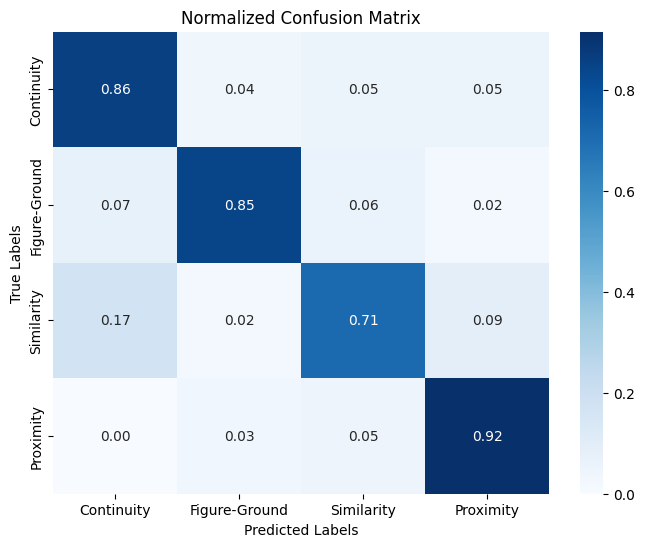

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Test the model on the fixed test set after all epochs
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'], output_dict=True)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'], yticklabels=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


ROC AUC Score: 0.8898


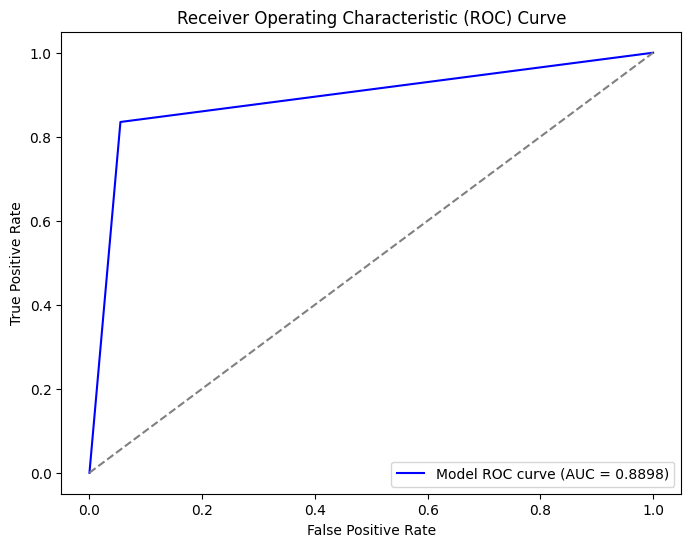

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels (One-hot encoding for multi-class classification)
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # Adjust the number of classes accordingly
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3])  # Adjust the number of classes accordingly

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels_bin, all_preds_bin, average='macro', multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_bin.ravel(), all_preds_bin.ravel())  # Flattening the arrays for plotting
plt.figure(figsize=(8, 6))

# Plot the ROC AUC curve for each class
plt.plot(fpr, tpr, color='blue', label=f'Model ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal (random classifier) line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# **EfficientNet**

Loaded pretrained weights for efficientnet-b7
Epoch [1/20], Train Accuracy: 40.48%, Validation Accuracy: 35.30%
Epoch [2/20], Train Accuracy: 54.79%, Validation Accuracy: 44.44%
Epoch [3/20], Train Accuracy: 57.82%, Validation Accuracy: 58.06%
Epoch [4/20], Train Accuracy: 63.74%, Validation Accuracy: 67.20%
Epoch [5/20], Train Accuracy: 66.44%, Validation Accuracy: 69.18%
Epoch [6/20], Train Accuracy: 69.55%, Validation Accuracy: 71.51%
Epoch [7/20], Train Accuracy: 72.32%, Validation Accuracy: 74.91%
Epoch [8/20], Train Accuracy: 73.39%, Validation Accuracy: 76.16%
Epoch [9/20], Train Accuracy: 73.93%, Validation Accuracy: 77.24%
Epoch [10/20], Train Accuracy: 74.09%, Validation Accuracy: 77.06%
Epoch [11/20], Train Accuracy: 74.36%, Validation Accuracy: 77.96%
Epoch [12/20], Train Accuracy: 73.70%, Validation Accuracy: 78.67%
Epoch [13/20], Train Accuracy: 76.01%, Validation Accuracy: 78.32%
Epoch [14/20], Train Accuracy: 75.39%, Validation Accuracy: 79.57%
Epoch [15/20], Train Accu

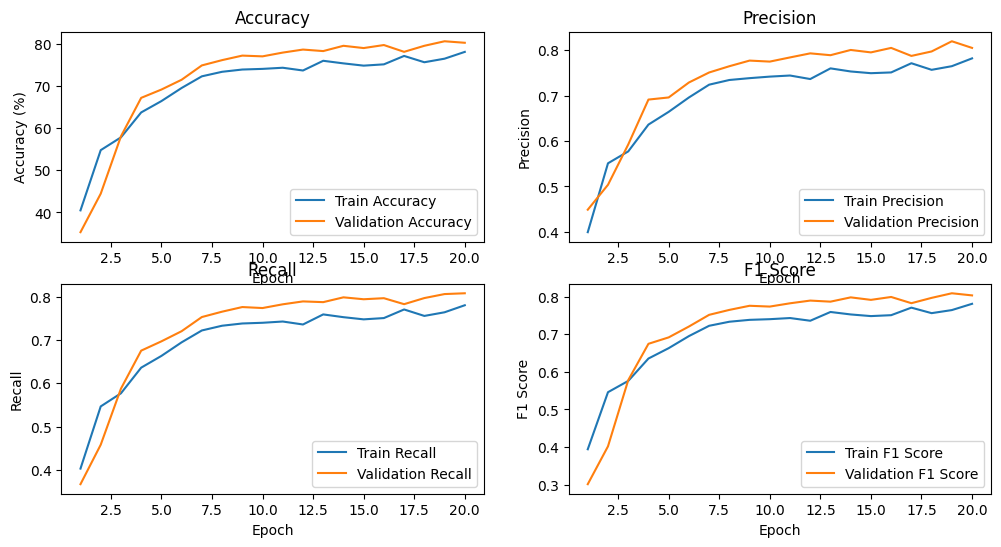

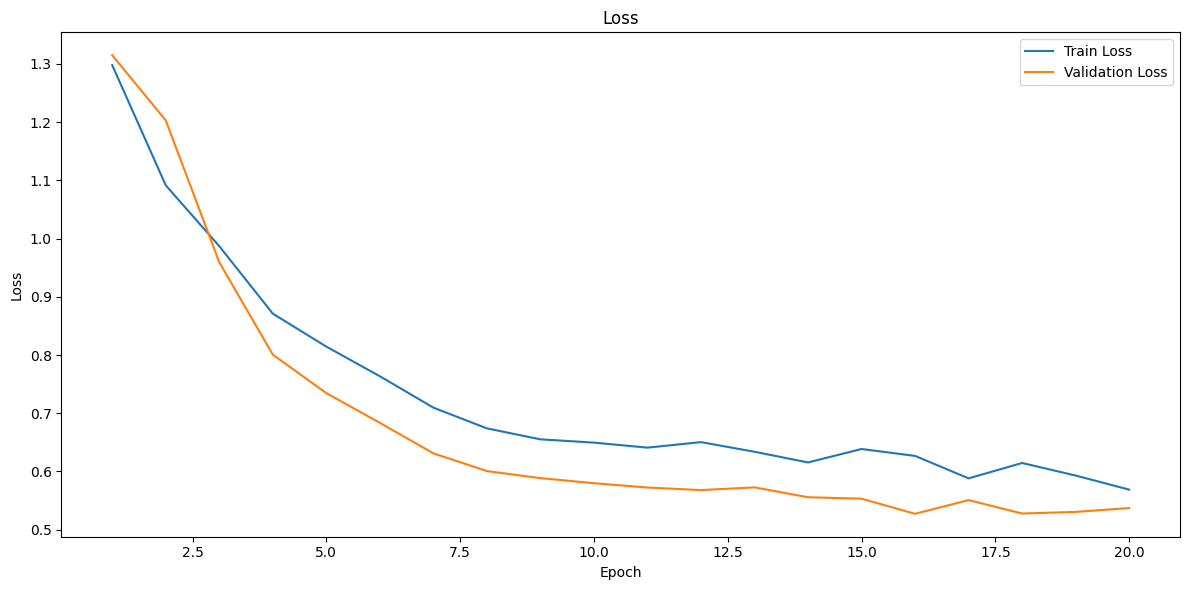

In [ ]:
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')

# Unfreeze the last few blocks
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 3 blocks
for block in model._blocks[-6:]:
    for param in block.parameters():
        param.requires_grad = True

# Unfreeze the final fully connected layers
for param in model._fc.parameters():
    param.requires_grad = True

# Adding Dropout to prevent overfitting
model._fc = nn.Sequential(
    nn.Linear(model._fc.in_features, 128),
    nn.ReLU(),
#    nn.Dropout(p=0.125),  # Increase Dropout if the model overfits
    nn.Linear(128, 4),  # Adjust the number of output classes to 4 (or your target size)
)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)  # Increase weight decay if the model overfits

# Learning rate scheduler (StepLR example)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Storing the metrics
train_accuracy_list = []
val_accuracy_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []
train_f1_list = []
val_f1_list = []
train_loss_list = []
val_loss_list = []

# Training
num_epochs = 20
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Calculating training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Storing loss and predictions for later metrics calculation
        train_loss += loss.item()
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Storing loss and predictions for later metrics calculation
            val_loss += loss.item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculating metrics for train and validation
    train_accuracy = 100 * train_correct / train_total
    val_accuracy = 100 * val_correct / val_total

    # Precision, Recall, F1 for training and validation
    train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # Storing metrics for plotting
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)
    train_precision_list.append(train_precision)
    val_precision_list.append(val_precision)
    train_recall_list.append(train_recall)
    val_recall_list.append(val_recall)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)
    train_loss_list.append(train_loss / len(trainloader))  # Average loss per batch
    val_loss_list.append(val_loss / len(valloader))  # Average loss per batch

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    scheduler.step()

# Plotting the metrics
epochs = range(1, num_epochs + 1)

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precision_list, label='Train Precision')
plt.plot(epochs, val_precision_list, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recall_list, label='Train Recall')
plt.plot(epochs, val_recall_list, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_list, label='Train F1 Score')
plt.plot(epochs, val_f1_list, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy: 79.39%

Classification Report:
{'Continuity': {'precision': 0.762962962962963, 'recall': 0.7463768115942029, 'f1-score': 0.7545787545787546, 'support': 138.0}, 'Figure-Ground': {'precision': 0.8688524590163934, 'recall': 0.7681159420289855, 'f1-score': 0.8153846153846154, 'support': 138.0}, 'Similarity': {'precision': 0.8290598290598291, 'recall': 0.697841726618705, 'f1-score': 0.7578125, 'support': 139.0}, 'Proximity': {'precision': 0.7445652173913043, 'recall': 0.958041958041958, 'f1-score': 0.8379204892966361, 'support': 143.0}, 'accuracy': 0.7939068100358423, 'macro avg': {'precision': 0.8013601171076224, 'recall': 0.7925941095709629, 'f1-score': 0.7914240898150015, 'support': 558.0}, 'weighted avg': {'precision': 0.8009008432964587, 'recall': 0.7939068100358423, 'f1-score': 0.7917804883949175, 'support': 558.0}}


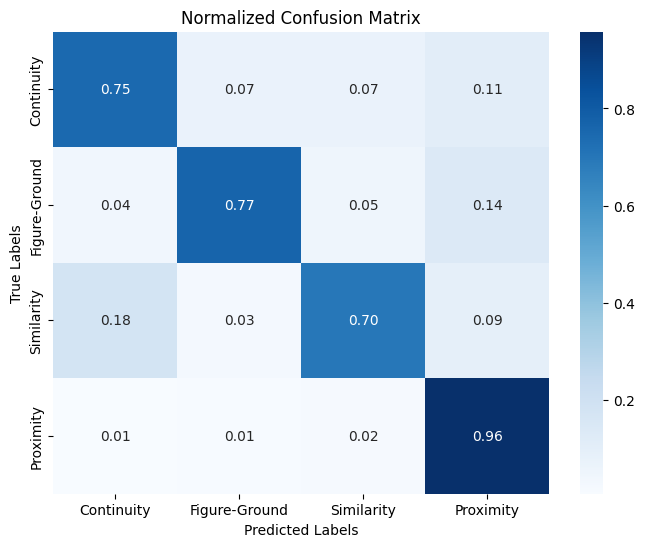

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Test the model on the fixed test set after all epochs
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'], output_dict=True)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'], yticklabels=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


ROC AUC Score: 0.8619


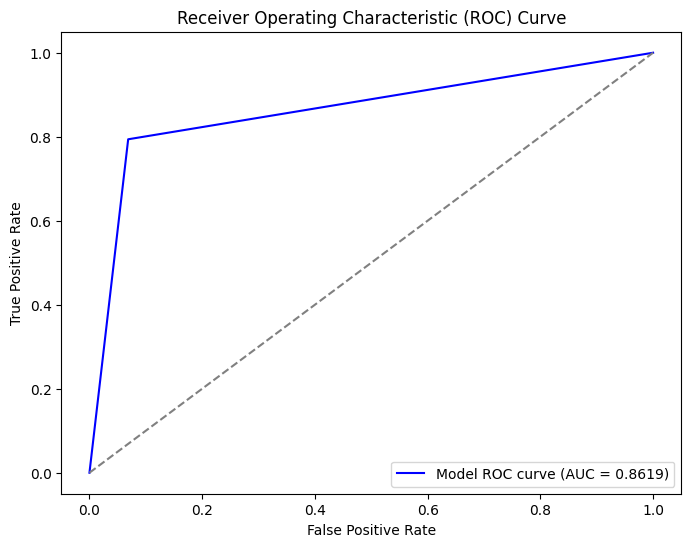

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels (One-hot encoding for multi-class classification)
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # Adjust the number of classes accordingly
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3])  # Adjust the number of classes accordingly

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels_bin, all_preds_bin, average='macro', multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_bin.ravel(), all_preds_bin.ravel())  # Flattening the arrays for plotting
plt.figure(figsize=(8, 6))

# Plot the ROC AUC curve for each class
plt.plot(fpr, tpr, color='blue', label=f'Model ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal (random classifier) line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# VGG16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Accuracy: 31.26%, Validation Accuracy: 47.31%
Epoch [2/20], Train Accuracy: 52.13%, Validation Accuracy: 55.38%
Epoch [3/20], Train Accuracy: 61.17%, Validation Accuracy: 58.42%
Epoch [4/20], Train Accuracy: 67.94%, Validation Accuracy: 67.92%
Epoch [5/20], Train Accuracy: 73.51%, Validation Accuracy: 72.94%
Epoch [6/20], Train Accuracy: 78.47%, Validation Accuracy: 77.78%
Epoch [7/20], Train Accuracy: 80.58%, Validation Accuracy: 82.08%
Epoch [8/20], Train Accuracy: 84.51%, Validation Accuracy: 83.87%
Epoch [9/20], Train Accuracy: 87.20%, Validation Accuracy: 86.38%
Epoch [10/20], Train Accuracy: 87.77%, Validation Accuracy: 86.92%
Epoch [11/20], Train Accuracy: 89.85%, Validation Accuracy: 86.56%
Epoch [12/20], Train Accuracy: 89.81%, Validation Accuracy: 87.99%
Epoch [13/20], Train Accuracy: 88.77%, Validation Accuracy: 87.10%
Epoch [14/20], Train Accuracy: 89.08%, Validation Accuracy: 90.86%
Epoch [15/20], Train Accuracy: 88.20%, Validation Accuracy: 87.10%
Epoc

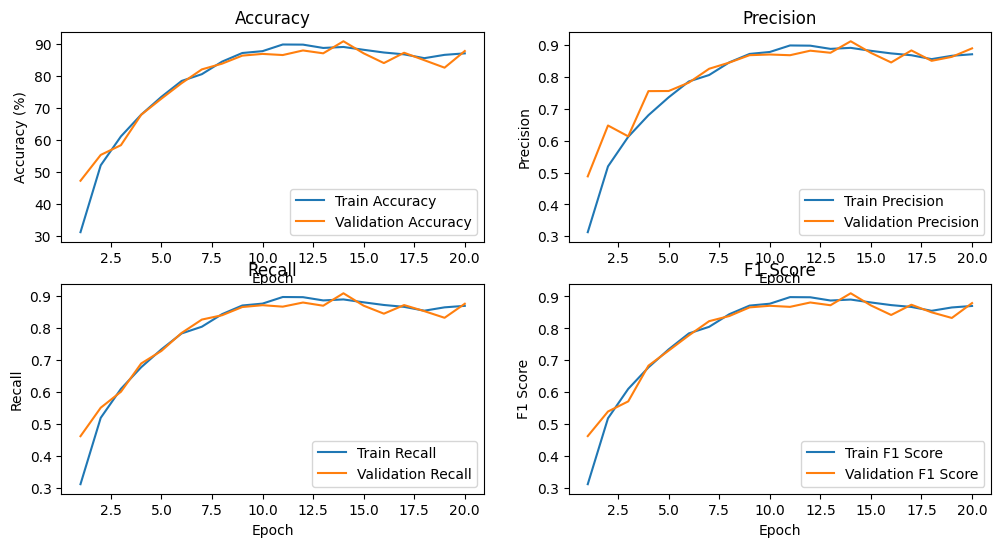

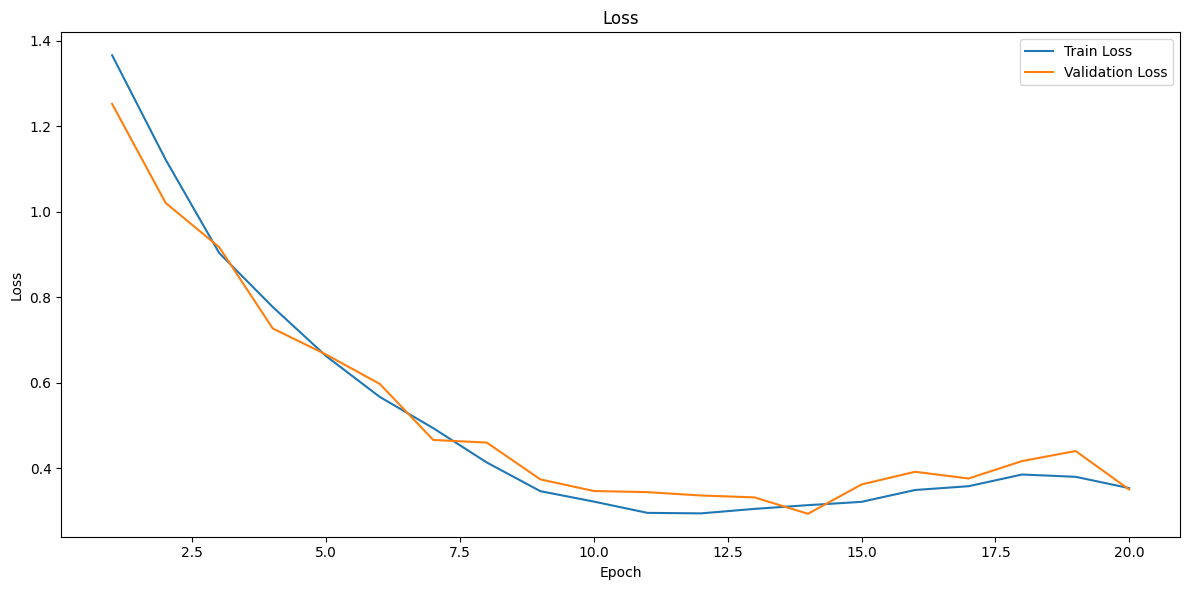

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Initialize the model VGG16
model = models.vgg16(pretrained=True)

# Unfreeze all layers initially
for param in model.parameters():
    param.requires_grad = True

# Adding Dropout to prevent overfitting
model.classifier[6] = nn.Sequential(
    nn.Linear(model.classifier[6].in_features, 128),
    nn.ReLU(),
    nn.Dropout(p=0.125),  # Increase Dropout if the model overfits
    nn.Linear(128, 4),
)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001,
                       weight_decay=0.001)  # Increase weight decay if the model overfits

# Learning rate scheduler (StepLR example)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Storing the metrics
train_accuracy_list = []
val_accuracy_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []
train_f1_list = []
val_f1_list = []
train_loss_list = []
val_loss_list = []

# Training
num_epochs = 20
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Calculating training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Storing loss and predictions for later metrics calculation
        train_loss += loss.item()
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Storing loss and predictions for later metrics calculation
            val_loss += loss.item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculating metrics for train and validation
    train_accuracy = 100 * train_correct / train_total
    val_accuracy = 100 * val_correct / val_total

    # Precision, Recall, F1 for training and validation
    train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
    val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # Storing metrics for plotting
    train_accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)
    train_precision_list.append(train_precision)
    val_precision_list.append(val_precision)
    train_recall_list.append(train_recall)
    val_recall_list.append(val_recall)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)
    train_loss_list.append(train_loss / len(trainloader))  # Average loss per batch
    val_loss_list.append(val_loss / len(valloader))  # Average loss per batch

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    scheduler.step()

# Plotting the metrics
epochs = range(1, num_epochs + 1)

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy')
plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precision_list, label='Train Precision')
plt.plot(epochs, val_precision_list, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recall_list, label='Train Recall')
plt.plot(epochs, val_recall_list, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_list, label='Train F1 Score')
plt.plot(epochs, val_f1_list, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy: 89.61%

Classification Report:
{'Continuity': {'precision': 0.8714285714285714, 'recall': 0.8840579710144928, 'f1-score': 0.8776978417266187, 'support': 138.0}, 'Figure-Ground': {'precision': 0.9603174603174603, 'recall': 0.8768115942028986, 'f1-score': 0.9166666666666666, 'support': 138.0}, 'Similarity': {'precision': 0.82, 'recall': 0.8848920863309353, 'f1-score': 0.8512110726643599, 'support': 139.0}, 'Proximity': {'precision': 0.9436619718309859, 'recall': 0.9370629370629371, 'f1-score': 0.9403508771929825, 'support': 143.0}, 'accuracy': 0.8960573476702509, 'macro avg': {'precision': 0.8988520008942544, 'recall': 0.8957061471528159, 'f1-score': 0.8964816145626568, 'support': 558.0}, 'weighted avg': {'precision': 0.8991122121017623, 'recall': 0.8960573476702509, 'f1-score': 0.8967935783104227, 'support': 558.0}}


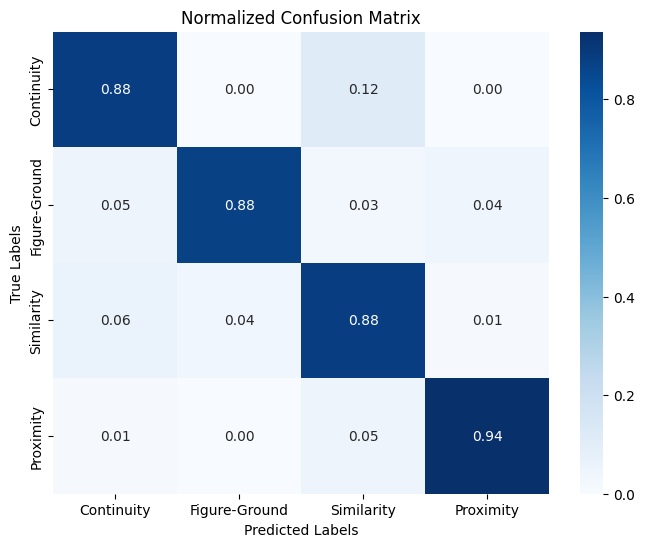

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Test the model on the fixed test set after all epochs
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'], output_dict=True)
print("\nClassification Report:")
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'], yticklabels=['Continuity', 'Figure-Ground', 'Similarity', 'Proximity'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


ROC AUC Score: 0.9305


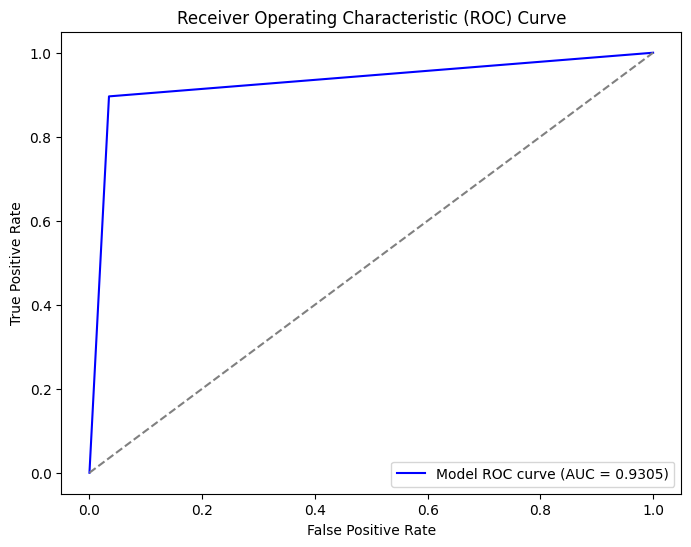

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels (One-hot encoding for multi-class classification)
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])  # Adjust the number of classes accordingly
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3])  # Adjust the number of classes accordingly

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels_bin, all_preds_bin, average='macro', multi_class='ovr')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_bin.ravel(), all_preds_bin.ravel())  # Flattening the arrays for plotting
plt.figure(figsize=(8, 6))

# Plot the ROC AUC curve for each class
plt.plot(fpr, tpr, color='blue', label=f'Model ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal (random classifier) line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
